In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch_geometric.transforms as T
from torch_geometric.utils import to_networkx
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling
from copy import deepcopy
from torch_geometric.loader import DataLoader

C:\Users\Molly\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
edges2011_df = pd.read_csv("tmp/2011/el_no_missing.csv")
locations_df = pd.read_csv("data/common/locations.csv")
nodes2011_df = pd.read_csv("tmp/2011/nl_no_missing.csv")

In [5]:
edges2013_df = pd.read_csv("tmp/2013/el_no_missing.csv")
nodes2013_df = pd.read_csv("tmp/2013/nl_no_missing.csv")

In [7]:
edges2015_df = pd.read_csv("tmp/2015/el_no_missing.csv")
nodes2015_df = pd.read_csv("tmp/2015/nl_no_missing.csv")

In [9]:
edges2017_df = pd.read_csv("tmp/2017/el_no_missing.csv")
nodes2017_df = pd.read_csv("tmp/2017/nl_no_missing.csv")

In [11]:
edges2011_df = pd.read_csv("data/2011/edgelist_threshold.csv")

In [13]:
edges2013_df = pd.read_csv("data/2013/edgelist_threshold.csv")

In [15]:
edges2015_df = pd.read_csv("data/2015/edgelist_threshold.csv")

In [17]:
edges2017_df = pd.read_csv("data/2017/edgelist_threshold.csv")

In [19]:
attribute_dict2011 = nodes2011_df.set_index('country_iso3')['gdp_us_dollar'].to_dict()

In [21]:
attribute_dict2013 = nodes2013_df.set_index('country_iso3')['gdp_us_dollar'].to_dict()

In [23]:
attribute_dict2015 = nodes2015_df.set_index('country_iso3')['gdp_us_dollar'].to_dict()

In [25]:
attribute_dict2017 = nodes2017_df.set_index('country_iso3')['gdp_us_dollar'].to_dict()

In [27]:
#Drop edges that specify internal trade
edges2011_df.drop(edges2011_df[edges2011_df['source'] == edges2011_df['target']].index, inplace=True)
edges2013_df.drop(edges2013_df[edges2013_df['source'] == edges2013_df['target']].index, inplace=True)
edges2015_df.drop(edges2015_df[edges2015_df['source'] == edges2015_df['target']].index, inplace=True)
edges2017_df.drop(edges2017_df[edges2017_df['source'] == edges2017_df['target']].index, inplace=True)

In [29]:
nodes2011_df = pd.merge(left=nodes2011_df, right=locations_df, how='inner', left_on='country_iso3', right_on='Alpha-3code')
countries2011 = nodes2011_df['country_iso3'].unique()

In [31]:
nodes2013_df = pd.merge(left=nodes2013_df, right=locations_df, how='inner', left_on='country_iso3', right_on='Alpha-3code')
countries2013 = nodes2013_df['country_iso3'].unique()

In [33]:
nodes2015_df = pd.merge(left=nodes2015_df, right=locations_df, how='inner', left_on='country_iso3', right_on='Alpha-3code')
countries2015 = nodes2015_df['country_iso3'].unique()

In [35]:
nodes2017_df = pd.merge(left=nodes2017_df, right=locations_df, how='inner', left_on='country_iso3', right_on='Alpha-3code')
countries2017 = nodes2017_df['country_iso3'].unique()

In [37]:
g2011 = nx.from_pandas_edgelist(edges2011_df, source='source', target='target', edge_attr=True, create_using=nx.DiGraph)

In [39]:
g2013 = nx.from_pandas_edgelist(edges2013_df, source='source', target='target', edge_attr=True, create_using=nx.DiGraph)

In [41]:
g2015 = nx.from_pandas_edgelist(edges2015_df, source='source', target='target', edge_attr=True, create_using=nx.DiGraph)

In [43]:
g2017 = nx.from_pandas_edgelist(edges2017_df, source='source', target='target', edge_attr=True, create_using=nx.DiGraph)

In [45]:
nx.set_node_attributes(g2011, attribute_dict2011, 'gdp')


In [47]:
nx.set_node_attributes(g2013, attribute_dict2013, 'gdp')

In [49]:
nx.set_node_attributes(g2015, attribute_dict2015, 'gdp')

In [51]:
nx.set_node_attributes(g2017, attribute_dict2017, 'gdp')

In [53]:
# Convert NetworkX graph to PyG Data object
data2011 = from_networkx(g2011, group_edge_attrs=['weight'], group_node_attrs=['gdp'])

In [55]:
data2013 = from_networkx(g2013, group_edge_attrs=['weight'], group_node_attrs=['gdp'])
data2015 = from_networkx(g2015, group_edge_attrs=['weight'], group_node_attrs=['gdp'])
data2017 = from_networkx(g2017, group_edge_attrs=['weight'], group_node_attrs=['gdp'])

In [57]:
graph2011 = to_networkx(data2011, node_attrs=["x"])

In [59]:
graph2013 = to_networkx(data2013, node_attrs=["x"])
graph2015 = to_networkx(data2015, node_attrs=["x"])
graph2017 = to_networkx(data2017, node_attrs=["x"])

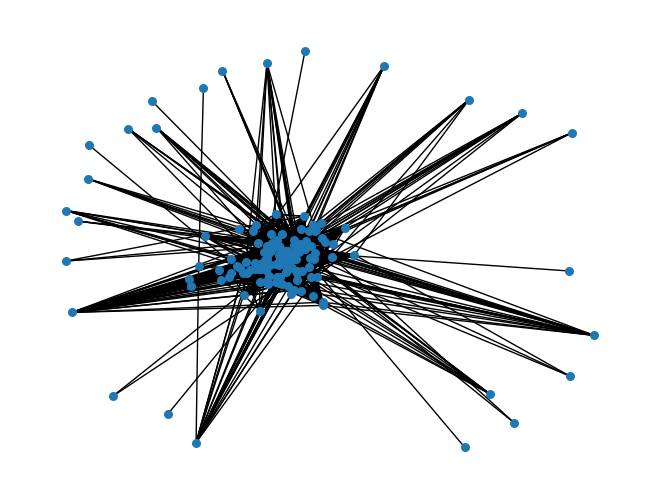

In [61]:
my_pos2011 = nx.spring_layout(graph2011,seed = 100)
nx.draw(graph2011, pos=my_pos2011, node_size = 30, arrows = False)

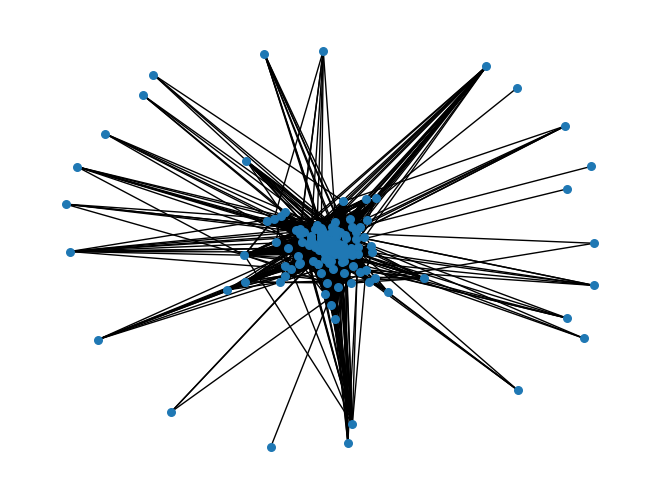

In [62]:
my_pos2013 = nx.spring_layout(graph2013,seed = 100)
nx.draw(graph2013, pos=my_pos2013, node_size = 30, arrows = False)

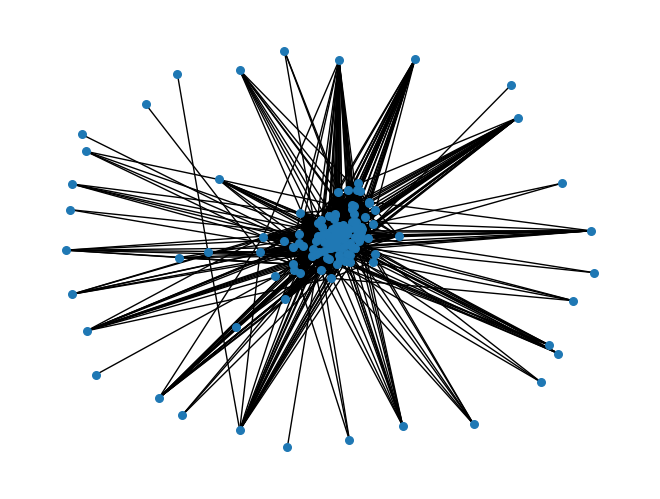

In [63]:
my_pos2015 = nx.spring_layout(graph2015,seed = 100)
nx.draw(graph2015, pos=my_pos2015, node_size = 30, arrows = False)

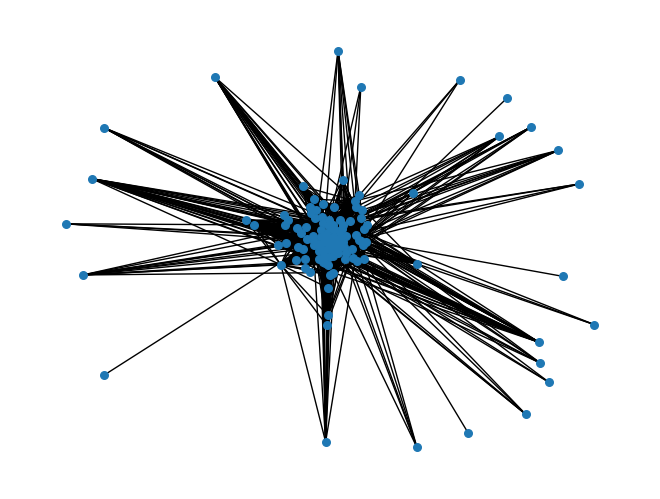

In [65]:
my_pos2017 = nx.spring_layout(graph2017,seed = 100)
nx.draw(graph2017, pos=my_pos2017, node_size = 30, arrows = False)

In [66]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, data.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output

In [69]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(
            dim=-1
        )  # product of a pair of nodes on each edge

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [106]:
def train_link_predictor_on_loader(model,train_loader,val_data,optimizer,criterion,n_epochs=100):
    for epoch in range(1, n_epochs+1):
        model.train()
        total_loss = 0.0

        for batch in train_loader:
            # mark all existing edges as positive
            batch.edge_label_index = batch.edge_index
            batch.edge_label       = torch.ones(batch.edge_index.size(1), dtype=torch.float)

            optimizer.zero_grad()
            
            z = model.encode(batch.x, batch.edge_index)
            # sampling training negatives for every training epoch
            neg_edge_index = negative_sampling(edge_index = batch.edge_index,num_nodes  = batch.num_nodes, num_neg_samples= batch.edge_label_index.size(1), method= 'sparse')

        
            edge_label_index = torch.cat([batch.edge_label_index, neg_edge_index], dim=-1)
            edge_label       = torch.cat([
                batch.edge_label,
                batch.edge_label.new_zeros(neg_edge_index.size(1))
            ], dim=0)



            out = model.decode(z, edge_label_index).view(-1)
            loss   = criterion(out, edge_label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_auc = eval_link_predictor(model, val_data)

        avg_loss = total_loss / len(train_loader)
        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d}, Train Loss: {avg_loss:.4f}, Val AUC: {val_auc:.3f}")
    return model

In [108]:
def train_one_epoch_loader(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    
    for batch in train_loader:
        batch.edge_label_index = batch.edge_index
        batch.edge_label       = torch.ones(
            batch.edge_index.size(1),
            dtype=torch.float,
            device=batch.x.device
        )

        optimizer.zero_grad()
        z = model.encode(batch.x, batch.edge_index)

        neg_edge_index = negative_sampling(
            edge_index     = batch.edge_index,
            num_nodes      = batch.num_nodes,
            num_neg_samples= batch.edge_label_index.size(1),
            method         = 'sparse',
        )

        edge_label_index = torch.cat([batch.edge_label_index, neg_edge_index], dim=-1)
        edge_label       = torch.cat([
            batch.edge_label,
            batch.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)


        out = model.decode(z, edge_label_index).view(-1)
        loss   = criterion(out, edge_label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


In [110]:
@torch.no_grad()
def eval_link_predictor(model, data):

    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [112]:
train_data1 = data2011
train_data2 = data2013
val_data   = data2015
test_data  = data2017

In [114]:
train_data1.edge_label_index = train_data1.edge_index
train_data1.edge_label       = torch.ones(train_data1.edge_index.size(1), dtype=torch.float)
train_data2.edge_label_index = train_data2.edge_index
train_data2.edge_label       = torch.ones(train_data2.edge_index.size(1), dtype=torch.float)

In [116]:
pos_val = val_data.edge_index
neg_val = negative_sampling(edge_index=pos_val,num_nodes=val_data.num_nodes,num_neg_samples=pos_val.size(1),)
val_data.edge_label_index = torch.cat([pos_val, neg_val], dim=-1)
val_data.edge_label       = torch.cat([torch.ones(pos_val.size(1)),torch.zeros(neg_val.size(1))], dim=0)

pos_test = test_data.edge_index
neg_test = negative_sampling(edge_index=pos_test,num_nodes=test_data.num_nodes,num_neg_samples=pos_test.size(1),)
test_data.edge_label_index = torch.cat([pos_test, neg_test], dim=-1)
test_data.edge_label       = torch.cat([torch.ones(pos_test.size(1)),torch.zeros(neg_test.size(1))], dim=0)

In [118]:
all_train_x = torch.cat([train_data1.x, train_data2.x], dim=0)
feat_min, _ = all_train_x.min(dim=0, keepdim=True)
feat_max, _ = all_train_x.max(dim=0, keepdim=True)

In [120]:
for d in (train_data1, train_data2, val_data, test_data):
    d.x = (d.x - feat_min) / (feat_max - feat_min)

In [ ]:
# feat_min1 = train_data1.x.min(dim=0, keepdim=True).values
# feat_max1 = train_data1.x.max(dim=0, keepdim=True).values
# feat_min2 = train_data2.x.min(dim=0, keepdim=True).values
# feat_max2 = train_data2.x.max(dim=0, keepdim=True).values

# train_data1.x = (train_data1.x - feat_min1) / (feat_max1 - feat_min1)
# train_data2.x = (train_data2.x - feat_min2) / (feat_max2 - feat_min2)
# val_data.x   = (val_data.x   - feat_min1) / (feat_max1 - feat_min1)
# test_data.x  = (test_data.x  - feat_min1) / (feat_max1 - feat_min1)

In [122]:
train_loader = DataLoader([train_data1, train_data2], batch_size=1, shuffle=True)
model = Net(train_data1.num_features, 128, 64)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
model = train_link_predictor(model, train_loader, val_data, optimizer, criterion)
test_auc = eval_link_predictor(model, test_data)
print(f"Test: {test_auc:.3f}")

Epoch 010, Train Loss: 0.5687, Val AUC: 0.923
Epoch 020, Train Loss: 0.5280, Val AUC: 0.857
Epoch 030, Train Loss: 0.5216, Val AUC: 0.844
Epoch 040, Train Loss: 0.5175, Val AUC: 0.859
Epoch 050, Train Loss: 0.5227, Val AUC: 0.877
Epoch 060, Train Loss: 0.5349, Val AUC: 0.870
Epoch 070, Train Loss: 0.5263, Val AUC: 0.887
Epoch 080, Train Loss: 0.5243, Val AUC: 0.887
Epoch 090, Train Loss: 0.5149, Val AUC: 0.867
Epoch 100, Train Loss: 0.5123, Val AUC: 0.882
Test: 0.893


In [91]:
model2 = Net(train_data1.num_features, 128, 64)
optimizer = torch.optim.Adam(params=model2.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
best_val_auc = 0.0
best_weights = None

for epoch in range(1,101):
    train_loss = train_one_epoch_loader(model2, train_loader, optimizer, criterion)
    val_auc    = eval_link_predictor(model2, val_data)
    if epoch %10 == 0:
        print(f"Epoch {epoch:03d}, Train Loss {train_loss:.4f}, Val AUC {val_auc:.3f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_weights = deepcopy(model2.state_dict())

print(f"Best Val AUC: {best_val_auc:.3f}")

# Load best model and test
model2.load_state_dict(best_weights)
test_auc = eval_link_predictor(model2, test_data)
print(f"Test AUC (best‐epoch): {test_auc:.3f}")

Epoch 010, Train Loss 0.5691, Val AUC 0.925
Epoch 020, Train Loss 0.5257, Val AUC 0.846
Epoch 030, Train Loss 0.5212, Val AUC 0.846
Epoch 040, Train Loss 0.5161, Val AUC 0.861
Epoch 050, Train Loss 0.5158, Val AUC 0.853
Epoch 060, Train Loss 0.5260, Val AUC 0.847
Epoch 070, Train Loss 0.5179, Val AUC 0.859
Epoch 080, Train Loss 0.5134, Val AUC 0.856
Epoch 090, Train Loss 0.5151, Val AUC 0.868
Epoch 100, Train Loss 0.5266, Val AUC 0.876
Best Val AUC: 0.931
Test AUC (best‐epoch): 0.926
